In [1]:
'''
GAN (generative adversarial network) : 적대적 생성 신경망
GAN은 생성하는 모델
GAN은 적대적으로 학습 - 가짜 이미지를 생성하는 생성자와 이미지의 진위를 판별하는 판별자
GAN은 인공 신경망 모델 - 생성자, 판별자 모두 신경망
비지도 학습
'''

'''
여러가지 가짜 이미지를 생성하는 생성자, 진짜 이미지와 가짜 이미지를 구분하는 판별자 존재
'''

'\n여러가지 가짜 이미지를 생성하는 생성자, 진짜 이미지와 가짜 이미지를 구분하는 판별자 존재\n'

In [30]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# 하이퍼파라미터
EPOCHS = 500
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 장치를 사용합니다 : ", DEVICE)

다음 장치를 사용합니다 :  cpu


In [6]:
# Fashine MNIST 데이터셋
trainset = datasets.FashionMNIST('./data',
                                train=True,
                                download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))
                                ]))
train_loader = torch.utils.data.DataLoader(
                dataset = trainset,
                batch_size = BATCH_SIZE,
                shuffle = True)

26427392it [01:10, 1446848.32it/s]                              

In [7]:
# Tanh 활성화 함수는 결괏값을 -1, 1사이로 압축하는 역할
# 무작위 텐서를 입력하는 이유는 생성자가 실제 데이터의 분포를 배우는 것이기 때문

# 생성자 (Generator)
G = nn.Sequential(
    nn.Linear(64, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 784),
    nn.Tanh()
)

# 판별자 (Discriminator)
D = nn.Sequential(
    nn.Linear(784, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

In [8]:
# 모델의 가중치를 지정한 장치로 보내기
D = D.to(DEVICE)
G = G.to(DEVICE)

# 이진 교차 엔트로피 오차 함수와
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

In [29]:
# 학습
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # 진짜와 가짜 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
        
        # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # 무작위 텐서로 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
        fake_images = G(z)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake
        
        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차 계산
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        
        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    # 학습 진행 알아보기
    print('이폭 [{}/{}] d_loss:{:.4f} g_loss:{:.4f} D(x):{:.2f} D(G(z)):{:.2f}'
          .format(epoch, EPOCHS, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))


이폭 [0/500] d_loss:0.0227 g_loss:5.6821 D(x):1.00 D(G(z)):0.02
이폭 [1/500] d_loss:0.0268 g_loss:11.1073 D(x):0.99 D(G(z)):0.00
이폭 [2/500] d_loss:0.0387 g_loss:6.1597 D(x):0.99 D(G(z)):0.01
이폭 [3/500] d_loss:0.3628 g_loss:4.9568 D(x):0.89 D(G(z)):0.03
이폭 [4/500] d_loss:0.0641 g_loss:7.0832 D(x):0.97 D(G(z)):0.00
이폭 [5/500] d_loss:0.0808 g_loss:7.1467 D(x):0.98 D(G(z)):0.02
이폭 [6/500] d_loss:0.1067 g_loss:5.8809 D(x):0.96 D(G(z)):0.02
이폭 [7/500] d_loss:0.1559 g_loss:4.8728 D(x):0.95 D(G(z)):0.03
이폭 [8/500] d_loss:0.0735 g_loss:8.2212 D(x):0.97 D(G(z)):0.01
이폭 [9/500] d_loss:0.3304 g_loss:3.4643 D(x):0.93 D(G(z)):0.11
이폭 [10/500] d_loss:0.1598 g_loss:5.5439 D(x):0.95 D(G(z)):0.02
이폭 [11/500] d_loss:0.2470 g_loss:4.7903 D(x):0.92 D(G(z)):0.03
이폭 [12/500] d_loss:0.3400 g_loss:3.7512 D(x):0.94 D(G(z)):0.16
이폭 [13/500] d_loss:0.2231 g_loss:4.4818 D(x):0.93 D(G(z)):0.08
이폭 [14/500] d_loss:0.3378 g_loss:4.8997 D(x):0.90 D(G(z)):0.08
이폭 [15/500] d_loss:0.2534 g_loss:4.4047 D(x):0.96 D(G(z)):0.11
이

이폭 [130/500] d_loss:0.7708 g_loss:1.9849 D(x):0.71 D(G(z)):0.23
이폭 [131/500] d_loss:1.0551 g_loss:1.5192 D(x):0.65 D(G(z)):0.31
이폭 [132/500] d_loss:1.1439 g_loss:1.3047 D(x):0.75 D(G(z)):0.42
이폭 [133/500] d_loss:0.7777 g_loss:1.6201 D(x):0.73 D(G(z)):0.28
이폭 [134/500] d_loss:0.8165 g_loss:1.5508 D(x):0.71 D(G(z)):0.28
이폭 [135/500] d_loss:0.9721 g_loss:1.4309 D(x):0.70 D(G(z)):0.35
이폭 [136/500] d_loss:0.9734 g_loss:1.3900 D(x):0.72 D(G(z)):0.36
이폭 [137/500] d_loss:0.8543 g_loss:2.4732 D(x):0.61 D(G(z)):0.14
이폭 [138/500] d_loss:0.8183 g_loss:1.7095 D(x):0.73 D(G(z)):0.30
이폭 [139/500] d_loss:1.4055 g_loss:1.7151 D(x):0.52 D(G(z)):0.31
이폭 [140/500] d_loss:0.8040 g_loss:1.7364 D(x):0.72 D(G(z)):0.28
이폭 [141/500] d_loss:1.2068 g_loss:1.1594 D(x):0.68 D(G(z)):0.40
이폭 [142/500] d_loss:0.9651 g_loss:1.2754 D(x):0.70 D(G(z)):0.35
이폭 [143/500] d_loss:0.8642 g_loss:1.4863 D(x):0.74 D(G(z)):0.31
이폭 [144/500] d_loss:1.1405 g_loss:1.7780 D(x):0.61 D(G(z)):0.32
이폭 [145/500] d_loss:0.9329 g_loss:1.7735

이폭 [259/500] d_loss:1.2497 g_loss:1.1646 D(x):0.60 D(G(z)):0.39
이폭 [260/500] d_loss:0.9954 g_loss:1.5693 D(x):0.64 D(G(z)):0.29
이폭 [261/500] d_loss:1.0121 g_loss:1.3995 D(x):0.69 D(G(z)):0.36
이폭 [262/500] d_loss:1.0051 g_loss:1.2859 D(x):0.65 D(G(z)):0.34
이폭 [263/500] d_loss:1.5990 g_loss:0.9289 D(x):0.54 D(G(z)):0.48
이폭 [264/500] d_loss:1.0952 g_loss:1.5039 D(x):0.54 D(G(z)):0.27
이폭 [265/500] d_loss:1.3070 g_loss:1.3666 D(x):0.59 D(G(z)):0.38
이폭 [266/500] d_loss:1.0855 g_loss:1.1501 D(x):0.62 D(G(z)):0.38
이폭 [267/500] d_loss:1.0224 g_loss:1.1320 D(x):0.66 D(G(z)):0.38
이폭 [268/500] d_loss:0.8939 g_loss:1.3915 D(x):0.67 D(G(z)):0.31
이폭 [269/500] d_loss:1.2046 g_loss:1.0632 D(x):0.59 D(G(z)):0.39
이폭 [270/500] d_loss:0.9461 g_loss:1.1939 D(x):0.70 D(G(z)):0.38
이폭 [271/500] d_loss:1.1704 g_loss:1.2079 D(x):0.57 D(G(z)):0.35
이폭 [272/500] d_loss:1.2622 g_loss:1.2142 D(x):0.58 D(G(z)):0.39
이폭 [273/500] d_loss:1.3959 g_loss:1.1160 D(x):0.62 D(G(z)):0.48
이폭 [274/500] d_loss:1.1753 g_loss:1.2798

이폭 [388/500] d_loss:1.3164 g_loss:1.1149 D(x):0.60 D(G(z)):0.44
이폭 [389/500] d_loss:0.8369 g_loss:1.4838 D(x):0.70 D(G(z)):0.31
이폭 [390/500] d_loss:0.9464 g_loss:1.3600 D(x):0.71 D(G(z)):0.37
이폭 [391/500] d_loss:1.1343 g_loss:1.4526 D(x):0.60 D(G(z)):0.32
이폭 [392/500] d_loss:1.1834 g_loss:1.3854 D(x):0.55 D(G(z)):0.32
이폭 [393/500] d_loss:1.2736 g_loss:1.1087 D(x):0.62 D(G(z)):0.41
이폭 [394/500] d_loss:1.1253 g_loss:1.2737 D(x):0.63 D(G(z)):0.37
이폭 [395/500] d_loss:1.1341 g_loss:1.2922 D(x):0.65 D(G(z)):0.39
이폭 [396/500] d_loss:1.1516 g_loss:1.1937 D(x):0.65 D(G(z)):0.42
이폭 [397/500] d_loss:1.3006 g_loss:1.0725 D(x):0.61 D(G(z)):0.42
이폭 [398/500] d_loss:1.0187 g_loss:1.1835 D(x):0.73 D(G(z)):0.43
이폭 [399/500] d_loss:0.9527 g_loss:1.5264 D(x):0.71 D(G(z)):0.34
이폭 [400/500] d_loss:1.1595 g_loss:1.1164 D(x):0.66 D(G(z)):0.41
이폭 [401/500] d_loss:1.0646 g_loss:1.2608 D(x):0.66 D(G(z)):0.34
이폭 [402/500] d_loss:1.0669 g_loss:1.6030 D(x):0.62 D(G(z)):0.31
이폭 [403/500] d_loss:1.1573 g_loss:1.0507

NameError: name 'np' is not defined

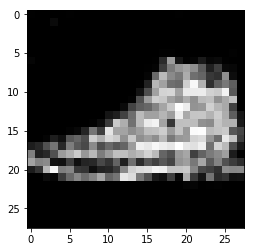

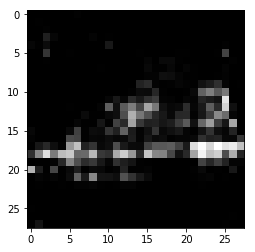

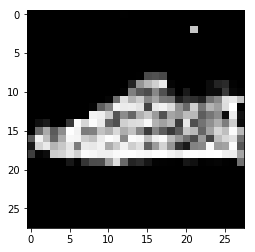

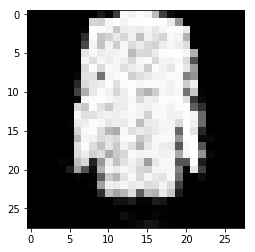

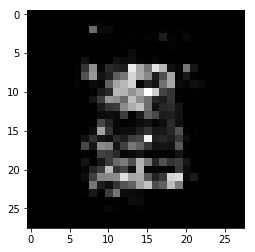

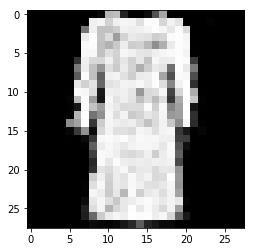

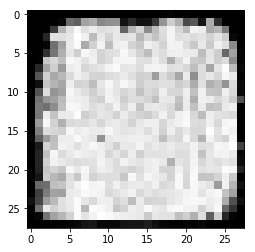

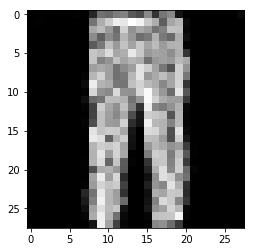

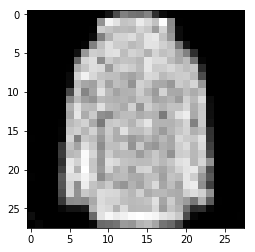

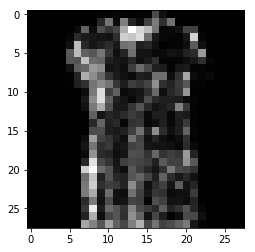

In [31]:
# 생성자가 만든 이미지 시각화 하기
z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
fake_images = G(z)
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i], (28, 28))
    plt.imshow(fake_images_img, cmap='gray')
    plt.show()

In [36]:
# 생성자 (Generator)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
                    nn.Linear(110, 256),
                    nn.LeakyReLU(0.2, inplace=True),
                    nn.Linear(256, 512),
                    nn.LeakyReLU(0.2, inplace=True),
                    nn.Linear(512, 1024),
                    nn.LeakyReLU(0.2, inplace=True),
                    nn.Linear(1024, 784),
                    nn.Tanh()
        )
    
    def forward(self, z, labels):
        c = self.embed(labels)
        x = torch.cat([z,c], 1)
        return self.model(x)
    
    

In [37]:
# 판별자 (Discriminator)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
                    nn.Linear(794, 1024),
                    nn.LeakyReLU(0.2, inplace=True),
                    nn.Dropout(0.3),
                    nn.Linear(1024, 512),
                    nn.Dropout(0.3),
                    nn.Linear(512, 256),
                    nn.LeakyReLU(0.2, inplace=True),
                    nn.Dropout(0.3),
                    nn.Linear(256,1),
                    nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        c = self.embed(labels)
        x = torch.cat([x, c], 1)
        return self.model(x)

In [38]:
# 모델 인스턴스를 만들고 모델의 가중치를 지정한 장치로 보내기
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

# 이진 교차 엔트로피 함수와
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr =0.0002)
g_optimizer = optim.Adam(G.parameters(), lr =0.0002)


total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)

        # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산 (데이터셋 레이블 입력)
        labels = labels.to(DEVICE)
        outputs = D(images, labels)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
    
        # 무작위 텐서와 무작위 레이블을 생성자에 입력해 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 100).to(DEVICE)
        g_label = torch.randint(0, 10, (BATCH_SIZE,)).to(DEVICE)
        fake_images = G(z, g_label)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
        outputs = D(fake_images, g_label)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake
        
        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차 계산(무작위 레이블 입력)
        fake_images = G(z, g_label)
        outputs = D(fake_images, g_label)
        g_loss = criterion(outputs, real_labels)

        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    print('이폭 [{}/{}] d_loss:{:.4f} g_loss: {:.4f} D(x):{:.2f} D(G(z)):{:.2f}'
          .format(epoch,
                  EPOCHS,
                  d_loss.item(),
                  g_loss.item(),
                  real_score.mean().item(),
                  fake_score.mean().item()))

이폭 [0/500] d_loss:0.0772 g_loss: 6.0711 D(x):0.95 D(G(z)):0.01
이폭 [1/500] d_loss:0.5201 g_loss: 3.2005 D(x):0.88 D(G(z)):0.19
이폭 [2/500] d_loss:0.3284 g_loss: 4.2057 D(x):0.88 D(G(z)):0.09
이폭 [3/500] d_loss:0.4390 g_loss: 3.4133 D(x):0.88 D(G(z)):0.14
이폭 [4/500] d_loss:0.3290 g_loss: 3.3726 D(x):0.93 D(G(z)):0.16
이폭 [5/500] d_loss:0.6743 g_loss: 2.2912 D(x):0.76 D(G(z)):0.20
이폭 [6/500] d_loss:0.6135 g_loss: 2.5102 D(x):0.85 D(G(z)):0.22
이폭 [7/500] d_loss:0.6014 g_loss: 2.0466 D(x):0.80 D(G(z)):0.23
이폭 [8/500] d_loss:0.8014 g_loss: 1.8350 D(x):0.76 D(G(z)):0.24
이폭 [9/500] d_loss:0.8230 g_loss: 2.1161 D(x):0.80 D(G(z)):0.31
이폭 [10/500] d_loss:0.9361 g_loss: 1.6525 D(x):0.74 D(G(z)):0.32
이폭 [11/500] d_loss:0.8484 g_loss: 1.6056 D(x):0.76 D(G(z)):0.32
이폭 [12/500] d_loss:1.0725 g_loss: 1.1506 D(x):0.62 D(G(z)):0.35
이폭 [13/500] d_loss:0.9433 g_loss: 2.1516 D(x):0.65 D(G(z)):0.22
이폭 [14/500] d_loss:0.8764 g_loss: 1.2278 D(x):0.68 D(G(z)):0.35
이폭 [15/500] d_loss:0.9077 g_loss: 1.6155 D(x):0.68

이폭 [128/500] d_loss:1.1514 g_loss: 1.0781 D(x):0.60 D(G(z)):0.39
이폭 [129/500] d_loss:1.4176 g_loss: 0.9271 D(x):0.53 D(G(z)):0.45
이폭 [130/500] d_loss:1.1412 g_loss: 1.3700 D(x):0.64 D(G(z)):0.37
이폭 [131/500] d_loss:1.2119 g_loss: 1.2717 D(x):0.61 D(G(z)):0.38
이폭 [132/500] d_loss:1.2593 g_loss: 1.0342 D(x):0.60 D(G(z)):0.45
이폭 [133/500] d_loss:1.1999 g_loss: 1.1797 D(x):0.57 D(G(z)):0.39
이폭 [134/500] d_loss:1.4493 g_loss: 0.9033 D(x):0.47 D(G(z)):0.44
이폭 [135/500] d_loss:1.2496 g_loss: 0.9465 D(x):0.60 D(G(z)):0.44
이폭 [136/500] d_loss:1.2003 g_loss: 0.9519 D(x):0.57 D(G(z)):0.40
이폭 [137/500] d_loss:1.4589 g_loss: 1.2243 D(x):0.57 D(G(z)):0.46
이폭 [138/500] d_loss:1.3658 g_loss: 1.1482 D(x):0.54 D(G(z)):0.41
이폭 [139/500] d_loss:1.1270 g_loss: 1.1469 D(x):0.65 D(G(z)):0.41
이폭 [140/500] d_loss:1.2640 g_loss: 0.9847 D(x):0.57 D(G(z)):0.42
이폭 [141/500] d_loss:1.2089 g_loss: 1.1624 D(x):0.61 D(G(z)):0.40
이폭 [142/500] d_loss:1.2225 g_loss: 1.2950 D(x):0.61 D(G(z)):0.41
이폭 [143/500] d_loss:1.147

이폭 [255/500] d_loss:1.1187 g_loss: 1.1834 D(x):0.65 D(G(z)):0.37
이폭 [256/500] d_loss:1.0763 g_loss: 1.2574 D(x):0.62 D(G(z)):0.36
이폭 [257/500] d_loss:1.1772 g_loss: 1.1715 D(x):0.61 D(G(z)):0.40
이폭 [258/500] d_loss:1.2242 g_loss: 0.9553 D(x):0.69 D(G(z)):0.50
이폭 [259/500] d_loss:1.1446 g_loss: 1.2921 D(x):0.62 D(G(z)):0.38
이폭 [260/500] d_loss:1.2539 g_loss: 0.9313 D(x):0.63 D(G(z)):0.44
이폭 [261/500] d_loss:1.1468 g_loss: 1.1283 D(x):0.59 D(G(z)):0.36
이폭 [262/500] d_loss:1.3009 g_loss: 1.0812 D(x):0.54 D(G(z)):0.41
이폭 [263/500] d_loss:1.1731 g_loss: 0.9681 D(x):0.62 D(G(z)):0.44
이폭 [264/500] d_loss:1.1818 g_loss: 1.0889 D(x):0.61 D(G(z)):0.40
이폭 [265/500] d_loss:1.0690 g_loss: 1.1709 D(x):0.60 D(G(z)):0.29
이폭 [266/500] d_loss:1.2862 g_loss: 0.9773 D(x):0.55 D(G(z)):0.42
이폭 [267/500] d_loss:1.2246 g_loss: 0.7923 D(x):0.61 D(G(z)):0.47
이폭 [268/500] d_loss:1.2096 g_loss: 0.9032 D(x):0.61 D(G(z)):0.43
이폭 [269/500] d_loss:1.2612 g_loss: 1.0705 D(x):0.54 D(G(z)):0.40
이폭 [270/500] d_loss:1.220

이폭 [382/500] d_loss:1.1508 g_loss: 1.1463 D(x):0.64 D(G(z)):0.42
이폭 [383/500] d_loss:1.3499 g_loss: 1.0699 D(x):0.54 D(G(z)):0.43
이폭 [384/500] d_loss:1.0595 g_loss: 1.0362 D(x):0.67 D(G(z)):0.40
이폭 [385/500] d_loss:1.3190 g_loss: 0.9131 D(x):0.55 D(G(z)):0.45
이폭 [386/500] d_loss:1.4035 g_loss: 0.8209 D(x):0.53 D(G(z)):0.47
이폭 [387/500] d_loss:1.3594 g_loss: 0.9518 D(x):0.54 D(G(z)):0.46
이폭 [388/500] d_loss:1.4943 g_loss: 0.9891 D(x):0.47 D(G(z)):0.42
이폭 [389/500] d_loss:1.1748 g_loss: 0.9299 D(x):0.56 D(G(z)):0.38
이폭 [390/500] d_loss:1.0639 g_loss: 1.2740 D(x):0.62 D(G(z)):0.35
이폭 [391/500] d_loss:1.1527 g_loss: 1.1325 D(x):0.65 D(G(z)):0.40
이폭 [392/500] d_loss:1.3083 g_loss: 1.1562 D(x):0.58 D(G(z)):0.40
이폭 [393/500] d_loss:1.3210 g_loss: 1.0274 D(x):0.57 D(G(z)):0.43
이폭 [394/500] d_loss:1.2835 g_loss: 0.8733 D(x):0.60 D(G(z)):0.46
이폭 [395/500] d_loss:1.2386 g_loss: 1.0139 D(x):0.59 D(G(z)):0.38
이폭 [396/500] d_loss:1.1073 g_loss: 1.1591 D(x):0.63 D(G(z)):0.38
이폭 [397/500] d_loss:1.282

In [ ]:
# 만들고 싶은 아이템 생성하고 시각화하기
item_number = 9 # 아이템 번호
z = torch.randn(1, 100).to(DEVICE) # 배치 크기 1
g_label = torch.full((1,), item_number, dtype=torch.long).to(DEVICE)
sample_images = G(z, g_label)

sample_images_img = np.reshape(sample_images.data.cpu().numpy()
                               [0],(28, 28))
plt.imshow(sample_images_img, cmap = 'gray')
plt.show()